In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torchinfo import summary

In [2]:
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
train_df = pd.read_csv("/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/train_answers.csv")
train_df

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6
...,...,...
12362,11503,4
12363,12201,6
12364,5489,3
12365,883,5


In [4]:
train_df["target_feature"].value_counts(normalize=True) 
# Видим, что в исходных данных всего 16 типов данных, а не 20, как в справочнике - потом надо переделать модель на 16 классов
# Потом можно добавить график

target_feature
0     0.203121
3     0.135845
9     0.098892
5     0.079405
6     0.064688
16    0.060888
4     0.060807
8     0.043099
2     0.042856
11    0.042694
12    0.037924
13    0.035740
18    0.033153
10    0.031536
14    0.018436
1     0.010916
Name: proportion, dtype: float64

In [5]:
# Если делать модель на 20 классах, 
# то на одних и тех же данных то метрика на валидации будет отличаться от метрики на нашей валидации.
# Например у нас f1 0.39, а на лидерборде около 0.5. Если классов сделать 16 (как на самом деле есть), 
# то на этих же предсказаниях метрика будет уже 0.49 (f1 чуствительна к количеству классов)
# Самое просто это перекодировать классы. Например (просто берем по уменьшении доли класс)

target_feature_to_class_id = {
    0:0,
    3:1,
    9:2,
    5:3,
    6:4,
    16:5,
    4:6,
    8:7,
    2:8,
    11:9,
    12:10,
    13:11,
    18:12,
    10:13,
    14:14,
    1:15,
}

class_id_to_target_feature = {v:k for k,v in target_feature_to_class_id.items()}

print(f'target_feature -> class_id', target_feature_to_class_id)
print(f'class_id -> target_feature', class_id_to_target_feature)

target_feature -> class_id {0: 0, 3: 1, 9: 2, 5: 3, 6: 4, 16: 5, 4: 6, 8: 7, 2: 8, 11: 9, 12: 10, 13: 11, 18: 12, 10: 13, 14: 14, 1: 15}
class_id -> target_feature {0: 0, 1: 3, 2: 9, 3: 5, 4: 6, 5: 16, 6: 4, 7: 8, 8: 2, 9: 11, 10: 12, 11: 13, 12: 18, 13: 10, 14: 14, 15: 1}


In [6]:
# Заменим 20 классов на новые идентификатры 16 классов
train_df['target_feature'] = train_df['target_feature'].replace(target_feature_to_class_id)
train_df

,img_id,target_feature
0,17363,8
1,8612,3
2,8244,0
3,9264,0
4,5382,4
...,...,...
12362,11503,6
12363,12201,4
12364,5489,1
12365,883,3


In [7]:
# Разделим данные на train и valid сохранением доли таргета
train_df, valid_df = train_test_split(train_df, train_size=0.8, random_state=5, shuffle=True, stratify=train_df["target_feature"])

In [8]:
# Проверим, что доли таргета не поменялись. Потом можно добавить график
print(train_df["target_feature"].value_counts(normalize=True))
print(valid_df["target_feature"].value_counts(normalize=True))

target_feature
0     0.203174
1     0.135854
2     0.098858
3     0.079450
4     0.064692
5     0.060851
6     0.060851
7     0.043061
8     0.042859
9     0.042656
10    0.037906
11    0.035783
12    0.033155
13    0.031537
14    0.018397
15    0.010917
Name: proportion, dtype: float64
target_feature
0     0.202910
1     0.135812
2     0.099030
3     0.079224
4     0.064673
5     0.061035
6     0.060631
7     0.043250
8     0.042846
9     0.042846
10    0.037995
11    0.035570
12    0.033145
13    0.031528
14    0.018593
15    0.010914
Name: proportion, dtype: float64


In [9]:
# Класс для загрузки картинок и информации о них
class ImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.data = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = str(self.data.iloc[idx]['img_id']) + ".jpg" 
        img_path = os.path.join(self.img_dir, img_name)
        
        # Читаем изображение
        image = read_image(img_path)
        
        # Получаем метку из CSV
        label = self.data.iloc[idx]['target_feature']
        
        # Применяем трансформации, если они заданы
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [10]:
from torchvision.transforms import v2
# https://pytorch.org/vision/stable/transforms.html

transform_train = v2.Compose([
    v2.Resize(256),    
    v2.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.RandomApply([v2.ColorJitter(0.1, 0.1, 0.1, 0.02)], p=0.8),
    v2.RandomPerspective(distortion_scale=0.2, p=0.3),
    v2.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.3),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_valid = v2.Compose([
    v2.Resize(224),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageDataset(
    df=train_df,
    img_dir="/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train",
    transform=transform_train
)

valid_dataset = ImageDataset(
    df=valid_df,
    img_dir="/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train",
    transform=transform_valid
)

In [11]:
# Класс для загрузки картинок и информации о них
class ImageDatasetCached(Dataset):
    def __init__(self, df, img_dir, transform_disk=None, transform_mem=None):
        self.data = df
        self.img_dir = img_dir
        self.transform_disk = transform_disk
        self.transform_mem = transform_mem

        print("Читаем даннные в память")
        self.cache_list = []
        for idx in range(len(self.data)):
            item = self.get_item_from_disk(idx)
            self.cache_list.append(item)
            
    def get_item_from_disk(self, idx):
        img_name = str(self.data.iloc[idx]['img_id']) + ".jpg" 
        img_path = os.path.join(self.img_dir, img_name)
        
        # Читаем изображение
        image = read_image(img_path)
        
        # Получаем метку из CSV
        label = self.data.iloc[idx]['target_feature']
        
        # Применяем трансформации, если они заданы
        if self.transform_disk:
            image = self.transform_disk(image)
            
        return image, label
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.cache_list[idx]
        
        # Применяем трансформации, если они заданы
        if self.transform_mem:
            image = self.transform_mem(image)
            
        return image, label

In [12]:
from torchvision.transforms import v2
# https://pytorch.org/vision/stable/transforms.html

transform_train_disk = v2.Compose([
    v2.Resize(256),    
])

transform_train_mem = v2.Compose([
    v2.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.RandomApply([v2.ColorJitter(0.1, 0.1, 0.1, 0.02)], p=0.8),
    v2.RandomPerspective(distortion_scale=0.2, p=0.3),
    v2.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.3),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_valid_disk = v2.Compose([
    v2.Resize(224),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageDatasetCached(
    df=train_df,
    img_dir="/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train",
    transform_disk=transform_train_disk,
    transform_mem=transform_train_mem,
)

valid_dataset = ImageDatasetCached(
    df=valid_df,
    img_dir="/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train",
    transform_disk=transform_valid_disk,
)

Читаем даннные в память
Читаем даннные в память


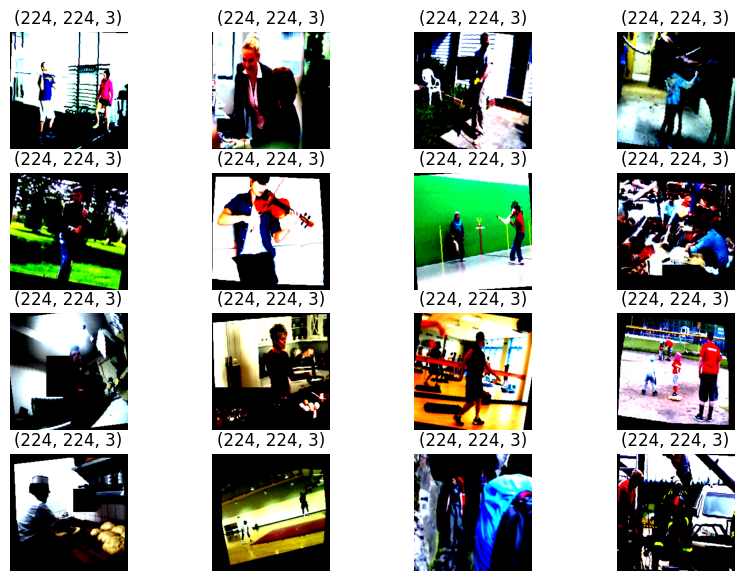

In [13]:
plt.figure(figsize=(10, 7))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img, label = train_dataset[i]
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis('off') 
    plt.title(f"{img.shape}")

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
# !rm -r /kaggle/working/models

In [16]:
def create_conv_model(dropout_conv = 0.1, dropout_linear = 0.3):
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(dropout_conv),
        
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(dropout_conv),
        
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(dropout_conv),
        
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(dropout_conv),
        
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(dropout_conv),
        
        # nn.Flatten(),
        # nn.Linear(in_features=25088, out_features=256),
        # nn.BatchNorm1d(256),
        # nn.ReLU(),
        # nn.Dropout(dropout_linear),
        # nn.Linear(in_features=256, out_features=16),

        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(in_features=512, out_features=16),
    
    )
    print(summary(model, (32,3,224,224)))
    return model

In [17]:
# Сделаем модель с skip-conection
def create_resnet18_model():
    class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride):
            super().__init__()
    
            # Основная логика
            self.main = nn.Sequential(
                nn.BatchNorm2d(in_channels),
                nn.ReLU(),
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                
            )
    
            # Логика skip-connection
            if (in_channels == out_channels) and (stride == 1):
                self.skip = nn.Identity()
            else:
                self.skip = nn.Sequential(
                    nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=0),
                    nn.BatchNorm2d(out_channels),
                )
    
            self.final_relu = nn.ReLU()
          
        def forward(self, x):
            out = self.main(x)
            out = out + self.skip(x)
            out = self.final_relu(out)
            return out
    
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    
        ResidualBlock(in_channels=64, out_channels=64, stride=1),
        ResidualBlock(in_channels=64, out_channels=64, stride=1),
        
        ResidualBlock(in_channels=64, out_channels=128, stride=2),
        ResidualBlock(in_channels=128, out_channels=128, stride=1),
    
        ResidualBlock(in_channels=128, out_channels=256, stride=2),
        ResidualBlock(in_channels=256, out_channels=256, stride=1),
    
        ResidualBlock(in_channels=256, out_channels=512, stride=2),
        ResidualBlock(in_channels=512, out_channels=512, stride=1),
    
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(in_features=512, out_features=16),
    )
    
    print(summary(model, (32,3,224,224)))
    return model

In [18]:
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import Loss, Accuracy, Average, RunningAverage, Precision, Recall, Fbeta
from ignite.utils import convert_tensor

def train_model(model, loss_fn, optimizer, train_dataloader, valid_dataloader, max_epoch, validation_patience, device, model_name_prefix='baseline'):
    # Создание trainer
    train_engine = create_supervised_trainer(
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        device=device,
        output_transform=lambda x, y, y_pred, loss: (loss.item(), y_pred, y)
    )
    
    # Добавляем метрики для подсчета train_loss
    train_loss = Average(output_transform=lambda x: x[0])
    train_loss.attach(train_engine, 'train_loss')
    
    # Создаем метрики Precision и Recall
    P = Precision(average=False, output_transform=lambda x: (x[1], x[2]))
    R = Recall(average=False, output_transform=lambda x: (x[1], x[2]))
    
    # Создаем F1-метрику (Fbeta с beta=1)
    # https://pytorch.org/ignite/generated/ignite.metrics.Fbeta.html#ignite.metrics.Fbeta
    train_metric = Fbeta(beta=1.0, precision=P, recall=R)
    train_metric.attach(train_engine, "train_f1")
    
    # Создание Engine для валидации
    valid_engine = create_supervised_evaluator(
        model=model,
        device=device,
        output_transform=lambda x, y, y_pred: (loss_fn(input=y_pred, target=y).item(), y_pred, y)
    )
    
    # Добавляем метрики для подсчета train_loss
    valid_loss = Average(output_transform=lambda x: x[0])
    valid_loss.attach(valid_engine, 'valid_loss')
    
    # Создаем метрики Precision и Recall для валидации
    P = Precision(average=False, output_transform=lambda x: (x[1], x[2]))
    R = Recall(average=False, output_transform=lambda x: (x[1], x[2]))
    
    # Создаем F1-метрику (Fbeta с beta=1)
    # https://pytorch.org/ignite/generated/ignite.metrics.Fbeta.html#ignite.metrics.Fbeta
    valid_metric = Fbeta(beta=1.0, precision=P, recall=R)
    valid_metric.attach(valid_engine, "valid_f1")
    
    train_loss_history = []
    train_f1_history = []
    valid_loss_history = []
    valid_f1_history = []
    
    # После каждой эпохи train_engine должен запускать valid_engine
    # Создадим обработчик события - конец эпохи у train_engine
    def compute_epoch_results(engine):
        valid_engine.run(valid_dataloader, epoch_length=None)
        train_loss = engine.state.metrics['train_loss']
        train_f1 = engine.state.metrics['train_f1']
        valid_loss = valid_engine.state.metrics['valid_loss']
        valid_f1 = valid_engine.state.metrics['valid_f1']
    
        train_loss_history.append(train_loss)
        train_f1_history.append(train_f1)
        valid_loss_history.append(valid_loss)
        valid_f1_history.append(valid_f1)
        
        print(f"Эпоха: {engine.state.epoch} train_loss: {train_loss:.4f} valid_loss: {valid_loss:.4f} train_f1: {train_f1:.4f} valid_f1: {valid_f1:.4f}")
    
    train_engine.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)
    
    # Добавляем EarlyStopping
    early_stop_handler = EarlyStopping(
        patience=validation_patience,  # количество эпох без улучшения
        score_function=lambda engine: valid_engine.state.metrics['valid_f1'],
        trainer=train_engine
    )
    
    # Прикрепляем обработчик к train_engine
    train_engine.add_event_handler(Events.EPOCH_COMPLETED, early_stop_handler)
    
    # Добавляем сохранение лучших моделей
    checkpointer = ModelCheckpoint(
        score_function=lambda engine: valid_engine.state.metrics['valid_f1'],
        dirname="models",
        filename_prefix=model_name_prefix,
        n_saved=3,
        create_dir=True,
        require_empty=False,
    )
    # Прикрепляем обработчик к train_engine
    train_engine.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'model': model})
    
    # Создаем прогресс-бар
    progress_bar = ProgressBar()
    
    # Привязываем к trainer
    progress_bar.attach(train_engine)
    
    # Запускаем обучение
    engine_output = train_engine.run(train_dataloader, max_epochs=max_epoch, epoch_length=None)

    # Формируем справочник с результатами
    train_result = {}
    train_result["train_loss_history"] = train_loss_history
    train_result["valid_loss_history"] = valid_loss_history
    train_result["train_f1_history"] = train_f1_history
    train_result["valid_f1_history"] = valid_f1_history
    train_result['checkpointer'] = checkpointer
    return train_result
    

/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [19]:
def predict_model(model, dataloader, device):
    test_engine = create_supervised_evaluator(
        model=model,
        device=device,
        output_transform=lambda x, y, y_pred: y_pred
    )
    
    pred_list = []
    
    def compute_epoch_results(engine):
        pred_list.append(engine.state.output.cpu().numpy())
        
    test_engine.add_event_handler(Events.ITERATION_COMPLETED, compute_epoch_results)
    
    # Создаем прогресс-бар
    progress_bar = ProgressBar()
    
    # Привязываем к trainer
    progress_bar.attach(test_engine)
    
    # Запускаем предсказание
    test_engine_output = test_engine.run(dataloader)

    # Объединяем предсказания в разных batch
    pred = np.concatenate(pred_list)
    print(pred.shape)

    # Максимум это предсказанный класс
    pred = pred.argmax(1)
    print(pred.shape)

    return pred

In [20]:
def plot_train_history(train_loss_history, valid_loss_history, train_f1_history, valid_f1_history):
    plt.plot(range(len(train_loss_history)), train_loss_history, label="train_loss")
    plt.plot(range(len(valid_loss_history)), valid_loss_history, label="valid_loss")
    
    best_epoch = np.argmax(np.array(valid_f1_history))
    plt.axvline(x=best_epoch, color='red', label="best valid_f1 epoch")
    
    plt.legend()
    plt.show()
    
    plt.plot(range(len(train_f1_history)), train_f1_history, label="train_f1")
    plt.plot(range(len(valid_f1_history)), valid_f1_history, label="valid_f1")
    
    plt.axvline(x=best_epoch, color='red', label="best valid_f1 epoch")
    
    plt.legend()
    plt.show()

def plot_train_history_from_results(train_results):
    plot_train_history(
        train_results['train_loss_history'],
        train_results['valid_loss_history'],
        train_results['train_f1_history'],
        train_results['valid_f1_history'],
    )

# Основной код обучения

In [21]:
# Создаем модель
model = create_conv_model()
model = model.to(device)

# Создаем loss функцию
loss_fn = nn.CrossEntropyLoss()

# Создаем оптимизатор, который будет обновлять веса модели с указаным lr
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Создаем даталоадеры с данными в батчах
batch_size = 256

# Создаем sampler, который для каждого элемента train учитывает долю таргета:
from torch.utils.data import WeightedRandomSampler
train_df['target_count'] = train_df.groupby('target_feature')['target_feature'].transform('count')
sampler = WeightedRandomSampler(weights=1. / train_df['target_count'].values, num_samples=200 * batch_size, replacement=True)

# num_workers=4, pin_memory=True - говрят должны в несколько потоков данные для gpu готовить
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=sampler, num_workers=4, pin_memory=True, prefetch_factor=4) 
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Запускаем обучение модели
train_results = train_model(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    max_epoch = 50,
    validation_patience = 5,
    model_name_prefix='convnet',
    device=device
)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 16]                  --
├─Conv2d: 1-1                            [32, 32, 224, 224]        896
├─BatchNorm2d: 1-2                       [32, 32, 224, 224]        64
├─ReLU: 1-3                              [32, 32, 224, 224]        --
├─MaxPool2d: 1-4                         [32, 32, 112, 112]        --
├─Dropout2d: 1-5                         [32, 32, 112, 112]        --
├─Conv2d: 1-6                            [32, 64, 112, 112]        18,496
├─BatchNorm2d: 1-7                       [32, 64, 112, 112]        128
├─ReLU: 1-8                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-9                         [32, 64, 56, 56]          --
├─Dropout2d: 1-10                        [32, 64, 56, 56]          --
├─Conv2d: 1-11                           [32, 128, 56, 56]         73,856
├─BatchNorm2d: 1-12                      [32, 128, 56, 56]         256
├─Re

/usr/local/lib/python3.10/dist-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


[1/200]   0%|           [00:00<?]

Эпоха: 1 train_loss: 2.5043 valid_loss: 2.3318 train_f1: 0.1777 valid_f1: 0.2081


[1/200]   0%|           [00:00<?]

Эпоха: 2 train_loss: 2.3269 valid_loss: 2.3135 train_f1: 0.2316 valid_f1: 0.2208


[1/200]   0%|           [00:00<?]

Эпоха: 3 train_loss: 2.2290 valid_loss: 2.1235 train_f1: 0.2693 valid_f1: 0.2493


[1/200]   0%|           [00:00<?]

Эпоха: 4 train_loss: 2.1409 valid_loss: 2.1256 train_f1: 0.2965 valid_f1: 0.2648


[1/200]   0%|           [00:00<?]

Эпоха: 5 train_loss: 2.0829 valid_loss: 2.0757 train_f1: 0.3168 valid_f1: 0.2789


[1/200]   0%|           [00:00<?]

Эпоха: 6 train_loss: 2.0262 valid_loss: 1.9844 train_f1: 0.3369 valid_f1: 0.3097


[1/200]   0%|           [00:00<?]

Эпоха: 7 train_loss: 1.9687 valid_loss: 1.9660 train_f1: 0.3582 valid_f1: 0.3221


[1/200]   0%|           [00:00<?]

Эпоха: 8 train_loss: 1.9077 valid_loss: 1.9607 train_f1: 0.3730 valid_f1: 0.3144


[1/200]   0%|           [00:00<?]

Эпоха: 9 train_loss: 1.8520 valid_loss: 1.8810 train_f1: 0.3930 valid_f1: 0.3620


[1/200]   0%|           [00:00<?]

Эпоха: 10 train_loss: 1.7865 valid_loss: 1.7952 train_f1: 0.4137 valid_f1: 0.3929


[1/200]   0%|           [00:00<?]

Эпоха: 11 train_loss: 1.7172 valid_loss: 1.7324 train_f1: 0.4357 valid_f1: 0.4074


[1/200]   0%|           [00:00<?]

Эпоха: 12 train_loss: 1.6586 valid_loss: 1.7108 train_f1: 0.4561 valid_f1: 0.4221


[1/200]   0%|           [00:00<?]

Эпоха: 13 train_loss: 1.5882 valid_loss: 1.6504 train_f1: 0.4784 valid_f1: 0.4480


[1/200]   0%|           [00:00<?]

Эпоха: 14 train_loss: 1.5077 valid_loss: 1.6459 train_f1: 0.5068 valid_f1: 0.4539


[1/200]   0%|           [00:00<?]

Эпоха: 15 train_loss: 1.4500 valid_loss: 1.5771 train_f1: 0.5247 valid_f1: 0.4707


[1/200]   0%|           [00:00<?]

Эпоха: 16 train_loss: 1.3861 valid_loss: 1.5610 train_f1: 0.5459 valid_f1: 0.4739


[1/200]   0%|           [00:00<?]

Эпоха: 17 train_loss: 1.3185 valid_loss: 1.5726 train_f1: 0.5675 valid_f1: 0.4682


[1/200]   0%|           [00:00<?]

Эпоха: 18 train_loss: 1.2629 valid_loss: 1.4885 train_f1: 0.5873 valid_f1: 0.5170


[1/200]   0%|           [00:00<?]

Эпоха: 19 train_loss: 1.2222 valid_loss: 1.4589 train_f1: 0.5975 valid_f1: 0.5159


[1/200]   0%|           [00:00<?]

Эпоха: 20 train_loss: 1.1542 valid_loss: 1.4200 train_f1: 0.6211 valid_f1: 0.5391


[1/200]   0%|           [00:00<?]

Эпоха: 21 train_loss: 1.1095 valid_loss: 1.3864 train_f1: 0.6333 valid_f1: 0.5495


[1/200]   0%|           [00:00<?]

Эпоха: 22 train_loss: 1.0752 valid_loss: 1.3923 train_f1: 0.6464 valid_f1: 0.5573


[1/200]   0%|           [00:00<?]

Эпоха: 23 train_loss: 1.0504 valid_loss: 1.3740 train_f1: 0.6570 valid_f1: 0.5504


[1/200]   0%|           [00:00<?]

Эпоха: 24 train_loss: 1.0061 valid_loss: 1.3262 train_f1: 0.6682 valid_f1: 0.5801


[1/200]   0%|           [00:00<?]

Эпоха: 25 train_loss: 0.9710 valid_loss: 1.3923 train_f1: 0.6805 valid_f1: 0.5707


[1/200]   0%|           [00:00<?]

Эпоха: 26 train_loss: 0.9416 valid_loss: 1.3494 train_f1: 0.6895 valid_f1: 0.5636


[1/200]   0%|           [00:00<?]

Эпоха: 27 train_loss: 0.9094 valid_loss: 1.3199 train_f1: 0.6976 valid_f1: 0.5610


[1/200]   0%|           [00:00<?]

Эпоха: 28 train_loss: 0.8864 valid_loss: 1.2931 train_f1: 0.7082 valid_f1: 0.5813


[1/200]   0%|           [00:00<?]

Эпоха: 29 train_loss: 0.8599 valid_loss: 1.3081 train_f1: 0.7171 valid_f1: 0.5801


[1/200]   0%|           [00:00<?]

Эпоха: 30 train_loss: 0.8355 valid_loss: 1.3192 train_f1: 0.7266 valid_f1: 0.5794


[1/200]   0%|           [00:00<?]

Эпоха: 31 train_loss: 0.8091 valid_loss: 1.2471 train_f1: 0.7331 valid_f1: 0.6103


[1/200]   0%|           [00:00<?]

Эпоха: 32 train_loss: 0.7975 valid_loss: 1.2767 train_f1: 0.7380 valid_f1: 0.5996


[1/200]   0%|           [00:00<?]

Эпоха: 33 train_loss: 0.7708 valid_loss: 1.2488 train_f1: 0.7471 valid_f1: 0.6123


[1/200]   0%|           [00:00<?]

Эпоха: 34 train_loss: 0.7591 valid_loss: 1.2854 train_f1: 0.7497 valid_f1: 0.6088


[1/200]   0%|           [00:00<?]

Эпоха: 35 train_loss: 0.7473 valid_loss: 1.2780 train_f1: 0.7556 valid_f1: 0.6029


[1/200]   0%|           [00:00<?]

Эпоха: 36 train_loss: 0.7238 valid_loss: 1.2518 train_f1: 0.7619 valid_f1: 0.6068


[1/200]   0%|           [00:00<?]

Эпоха: 37 train_loss: 0.7103 valid_loss: 1.2723 train_f1: 0.7687 valid_f1: 0.6169


[1/200]   0%|           [00:00<?]

Эпоха: 38 train_loss: 0.6896 valid_loss: 1.2357 train_f1: 0.7720 valid_f1: 0.6101


[1/200]   0%|           [00:00<?]

Эпоха: 39 train_loss: 0.6838 valid_loss: 1.2152 train_f1: 0.7746 valid_f1: 0.6209


[1/200]   0%|           [00:00<?]

Эпоха: 40 train_loss: 0.6671 valid_loss: 1.2860 train_f1: 0.7779 valid_f1: 0.6051


[1/200]   0%|           [00:00<?]

Эпоха: 41 train_loss: 0.6636 valid_loss: 1.2415 train_f1: 0.7836 valid_f1: 0.6134


[1/200]   0%|           [00:00<?]

Эпоха: 42 train_loss: 0.6458 valid_loss: 1.2629 train_f1: 0.7858 valid_f1: 0.6209


[1/200]   0%|           [00:00<?]

Эпоха: 43 train_loss: 0.6399 valid_loss: 1.2284 train_f1: 0.7897 valid_f1: 0.6292


[1/200]   0%|           [00:00<?]

Эпоха: 44 train_loss: 0.6257 valid_loss: 1.2623 train_f1: 0.7942 valid_f1: 0.6233


[1/200]   0%|           [00:00<?]

Эпоха: 45 train_loss: 0.6184 valid_loss: 1.2667 train_f1: 0.7964 valid_f1: 0.6240


[1/200]   0%|           [00:00<?]

Эпоха: 46 train_loss: 0.6046 valid_loss: 1.2107 train_f1: 0.8024 valid_f1: 0.6362


[1/200]   0%|           [00:00<?]

Эпоха: 47 train_loss: 0.5962 valid_loss: 1.2223 train_f1: 0.8055 valid_f1: 0.6297


[1/200]   0%|           [00:00<?]

Эпоха: 48 train_loss: 0.5870 valid_loss: 1.2092 train_f1: 0.8055 valid_f1: 0.6471


[1/200]   0%|           [00:00<?]

Эпоха: 49 train_loss: 0.5752 valid_loss: 1.2679 train_f1: 0.8106 valid_f1: 0.6387


[1/200]   0%|           [00:00<?]

Эпоха: 50 train_loss: 0.5767 valid_loss: 1.2515 train_f1: 0.8102 valid_f1: 0.6282


# Предсказание

In [22]:
# Соберем pandas DataFrame для тестовых данных и из него сделаем тестовый датасет
file_list = os.listdir('/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_test')
img_id_list = [int(file_name.split(".")[0]) for file_name in file_list]

In [23]:
test_df = pd.DataFrame({
    "img_id": img_id_list,
    "target_feature": -1
})
test_df

,img_id,target_feature
0,16916,-1
1,12666,-1
2,623,-1
3,11925,-1
4,2008,-1
...,...,...
5296,728,-1
5297,1656,-1
5298,3361,-1
5299,2599,-1


In [24]:
test_dataset = ImageDataset(
    df=test_df,
    img_dir="/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_test",
    transform=transform_valid
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [25]:
# Предскажем моделью с последней эпохи
test_pred = predict_model(model, test_dataloader, device)

# Сохраним предсказание в таблицу
test_df['target_feature'] = test_pred

# Мы заменяли 20 классов на наши 16 - теперь надо вернуть нормально
test_df['target_feature'] = test_df['target_feature'].replace(class_id_to_target_feature)

# В результатах требуется колонка id (маленькими буквами)
test_df["id"] = test_df['img_id']

# Запишим колонки id и target_feature в csv файл. Указываем index=False, чтобы не добавлялась еще одна колонка с индексом
test_df[['id', 'target_feature']].to_csv('result_last.csv', index=False)

[1/21]   5%|4          [00:00<?]

(5301, 16)
(5301,)


In [26]:
# Предскажем моделью с оптимальной эпохи
model_path = train_results['checkpointer'].last_checkpoint
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)

test_pred = predict_model(model, test_dataloader, device)

# Сохраним предсказание в таблицу
test_df['target_feature'] = test_pred

# Мы заменяли 20 классов на наши 16 - теперь надо вернуть нормально
test_df['target_feature'] = test_df['target_feature'].replace(class_id_to_target_feature)

# В результатах требуется колонка id (маленькими буквами)
test_df["id"] = test_df['img_id']

# Запишим колонки id и target_feature в csv файл. Указываем index=False, чтобы не добавлялась еще одна колонка с индексом
test_df[['id', 'target_feature']].to_csv('result_best_1.csv', index=False)

<ipython-input-26-e9f9f29bb83f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


[1/21]   5%|4          [00:00<?]

(5301, 16)
(5301,)
